# Case Study 2 : Hospital Readmission

Submitted by:

- Ravi Sivaraman
- Balaji Avvaru
- Apurv Mittal

The code for importing the data is combined with the inital loading of various analysis and visualization packages below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [2]:
# read diabetic csv files
diabetic_df = pd.read_csv('diabetic_data.csv')
diabetic_df.shape

(101766, 50)

In [3]:
diabetic_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Validate null values in the csv file
diabetic_df.isnull().sum().sum()

0

There are no null values in the dataset, but null values are coded as ?, first replace observations value ? with nan

In [5]:
# replace ? with nan
diabetic_df = diabetic_df.replace("?",np.nan)

In [6]:
# Validate null values in the csv file
print(diabetic_df.isnull().sum())
# print columns with null values
missing_data_columns = diabetic_df.columns[diabetic_df.isnull().any()]
missing_data_columns

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Index(['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3'],
      dtype='object')

In [7]:
diabetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

##### Target variable

In [8]:
# Convert target variable to a categorical 
diabetic_df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

There are three different values for target variable. We decided to reduce these values to two based on whether readmitted ot not (0 means not admitted and 1 means admitted) 

In [9]:
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('>30', 0)
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('<30', 1)
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('NO', 0)

In [10]:
diabetic_df['readmitted'].value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

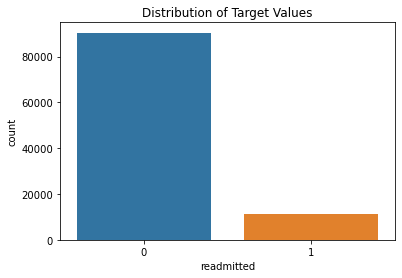

In [11]:
sns.countplot(x = "readmitted", data = diabetic_df)
plt.title("Distribution of Target Values")
plt.show()

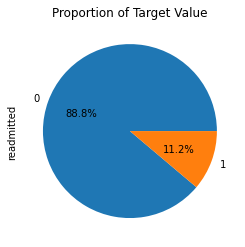

In [12]:
# Pie chart
diabetic_df.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

These two diagrams show us that our target variable is almost balanced distributed.

##### Missing data analysis and applying Imputation

In [13]:
missing_data_columns

Index(['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3'],
      dtype='object')

### apurv

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:

data_reduced = diabetic_df[["race", "gender", "age", "weight"]]

data_reduced

,race,gender,age,weight
0,Caucasian,Female,[0-10),NaN
1,Caucasian,Female,[10-20),NaN
2,AfricanAmerican,Female,[20-30),NaN
3,Caucasian,Male,[30-40),NaN
4,Caucasian,Male,[40-50),NaN
...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),NaN
101762,AfricanAmerican,Female,[80-90),NaN
101763,Caucasian,Male,[70-80),NaN
101764,Caucasian,Female,[80-90),NaN


In [16]:
data_reduced["gender"] = [1 if x=="Male" else 0 for x in data_reduced["gender"]]

data_reduced

,race,gender,age,weight
0,Caucasian,0,[0-10),NaN
1,Caucasian,0,[10-20),NaN
2,AfricanAmerican,0,[20-30),NaN
3,Caucasian,1,[30-40),NaN
4,Caucasian,1,[40-50),NaN
...,...,...,...,...
101761,AfricanAmerican,1,[70-80),NaN
101762,AfricanAmerican,0,[80-90),NaN
101763,Caucasian,1,[70-80),NaN
101764,Caucasian,0,[80-90),NaN


In [17]:
data_reduced['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [18]:
# replacing the missing race values with Caucasian
data_reduced['race'] = data_reduced['race'].fillna("Caucasian")

In [19]:
# One hot encoding Race
data_reduced_race = pd.get_dummies(data_reduced.race, prefix='race')
data_reduced_race=data_reduced_race.astype(float)

In [20]:
# One hot encoding age
data_reduced_age = pd.get_dummies(data_reduced.age, prefix='age')
data_reduced_age=data_reduced_age.astype(float)

In [21]:
data_reduced_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   age_[0-10)    101766 non-null  float64
 1   age_[10-20)   101766 non-null  float64
 2   age_[20-30)   101766 non-null  float64
 3   age_[30-40)   101766 non-null  float64
 4   age_[40-50)   101766 non-null  float64
 5   age_[50-60)   101766 non-null  float64
 6   age_[60-70)   101766 non-null  float64
 7   age_[70-80)   101766 non-null  float64
 8   age_[80-90)   101766 non-null  float64
 9   age_[90-100)  101766 non-null  float64
dtypes: float64(10)
memory usage: 7.8 MB


In [22]:
# creating DF of one hot encoded values
data = pd.concat([data_reduced,data_reduced_race,data_reduced_age],axis=1)

In [23]:
# drop race as its duplicate now
data=data.drop("race", axis=1)
data

,gender,age,weight,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,0,[0-10),NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,[10-20),NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,[20-30),NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,[30-40),NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,[40-50),NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,[70-80),NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101762,0,[80-90),NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101763,1,[70-80),NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101764,0,[80-90),NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# drop age as its duplicate now
data=data.drop("age", axis=1)
data

,gender,weight,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101762,0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101763,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101764,0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
# checking values for weight
data['weight'].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

In [26]:
# replacinf Weight values with average of the range

data['weight'] = data['weight'].replace('[0-25)', np.nan)
data['weight'] = data['weight'].replace('[25-50)', 37.5)
data['weight'] = data['weight'].replace('[50-75)', 62.5)
data['weight'] = data['weight'].replace('[75-100)', 87.5)
data['weight'] = data['weight'].replace('[100-125)', 112.5)
data['weight'] = data['weight'].replace('[125-150)', 137.5)
data['weight'] = data['weight'].replace('[150-175)', 162.5)
data['weight'] = data['weight'].replace('[175-200)', 187.5)
data['weight'] = data['weight'].replace('>200', 225)

In [27]:
# assigning all missing data rows to test data set
test_data = data[data["weight"].isna()]


In [28]:
# running regression to predict missing weight values
df_wona = data.dropna(axis=0)

y_train = df_wona["weight"]
X_train = df_wona.drop("weight", axis=1)
X_test = test_data.drop("weight", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# reference: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

In [42]:
X_test

,gender,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101762,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101763,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101764,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df

,0
0,35.15625
1,54.37500
2,74.96875
3,94.53125
4,101.75000
...,...
98612,91.37500
98613,74.12500
98614,90.56250
98615,73.31250


In [46]:
y_pred_df.isna().sum()

0    0
dtype: int64

In [43]:
X_test["weight"] =y_pred_df

In [44]:
X_test

,gender,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight
0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.15625
1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.37500
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.96875
3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,94.53125
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,101.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
101762,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
101763,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
101764,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN


In [31]:
# Original one hot encoded data
data

,gender,weight,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101762,0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101763,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101764,0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
# Data with weights as NA
test_data

,gender,weight,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100)
0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101762,0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101763,1,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101764,0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
# Replace NA values in test data with y_pred
test_data['weight'] = test_data.fillna(test_data['weight'], y_pred)

ValueError: Cannot specify both 'value' and 'method'.

In [39]:
data_reduced


,race,gender,age,weight
0,Caucasian,0,[0-10),NaN
1,Caucasian,0,[10-20),NaN
2,AfricanAmerican,0,[20-30),NaN
3,Caucasian,1,[30-40),NaN
4,Caucasian,1,[40-50),NaN
...,...,...,...,...
101761,AfricanAmerican,1,[70-80),NaN
101762,AfricanAmerican,0,[80-90),NaN
101763,Caucasian,1,[70-80),NaN
101764,Caucasian,0,[80-90),NaN


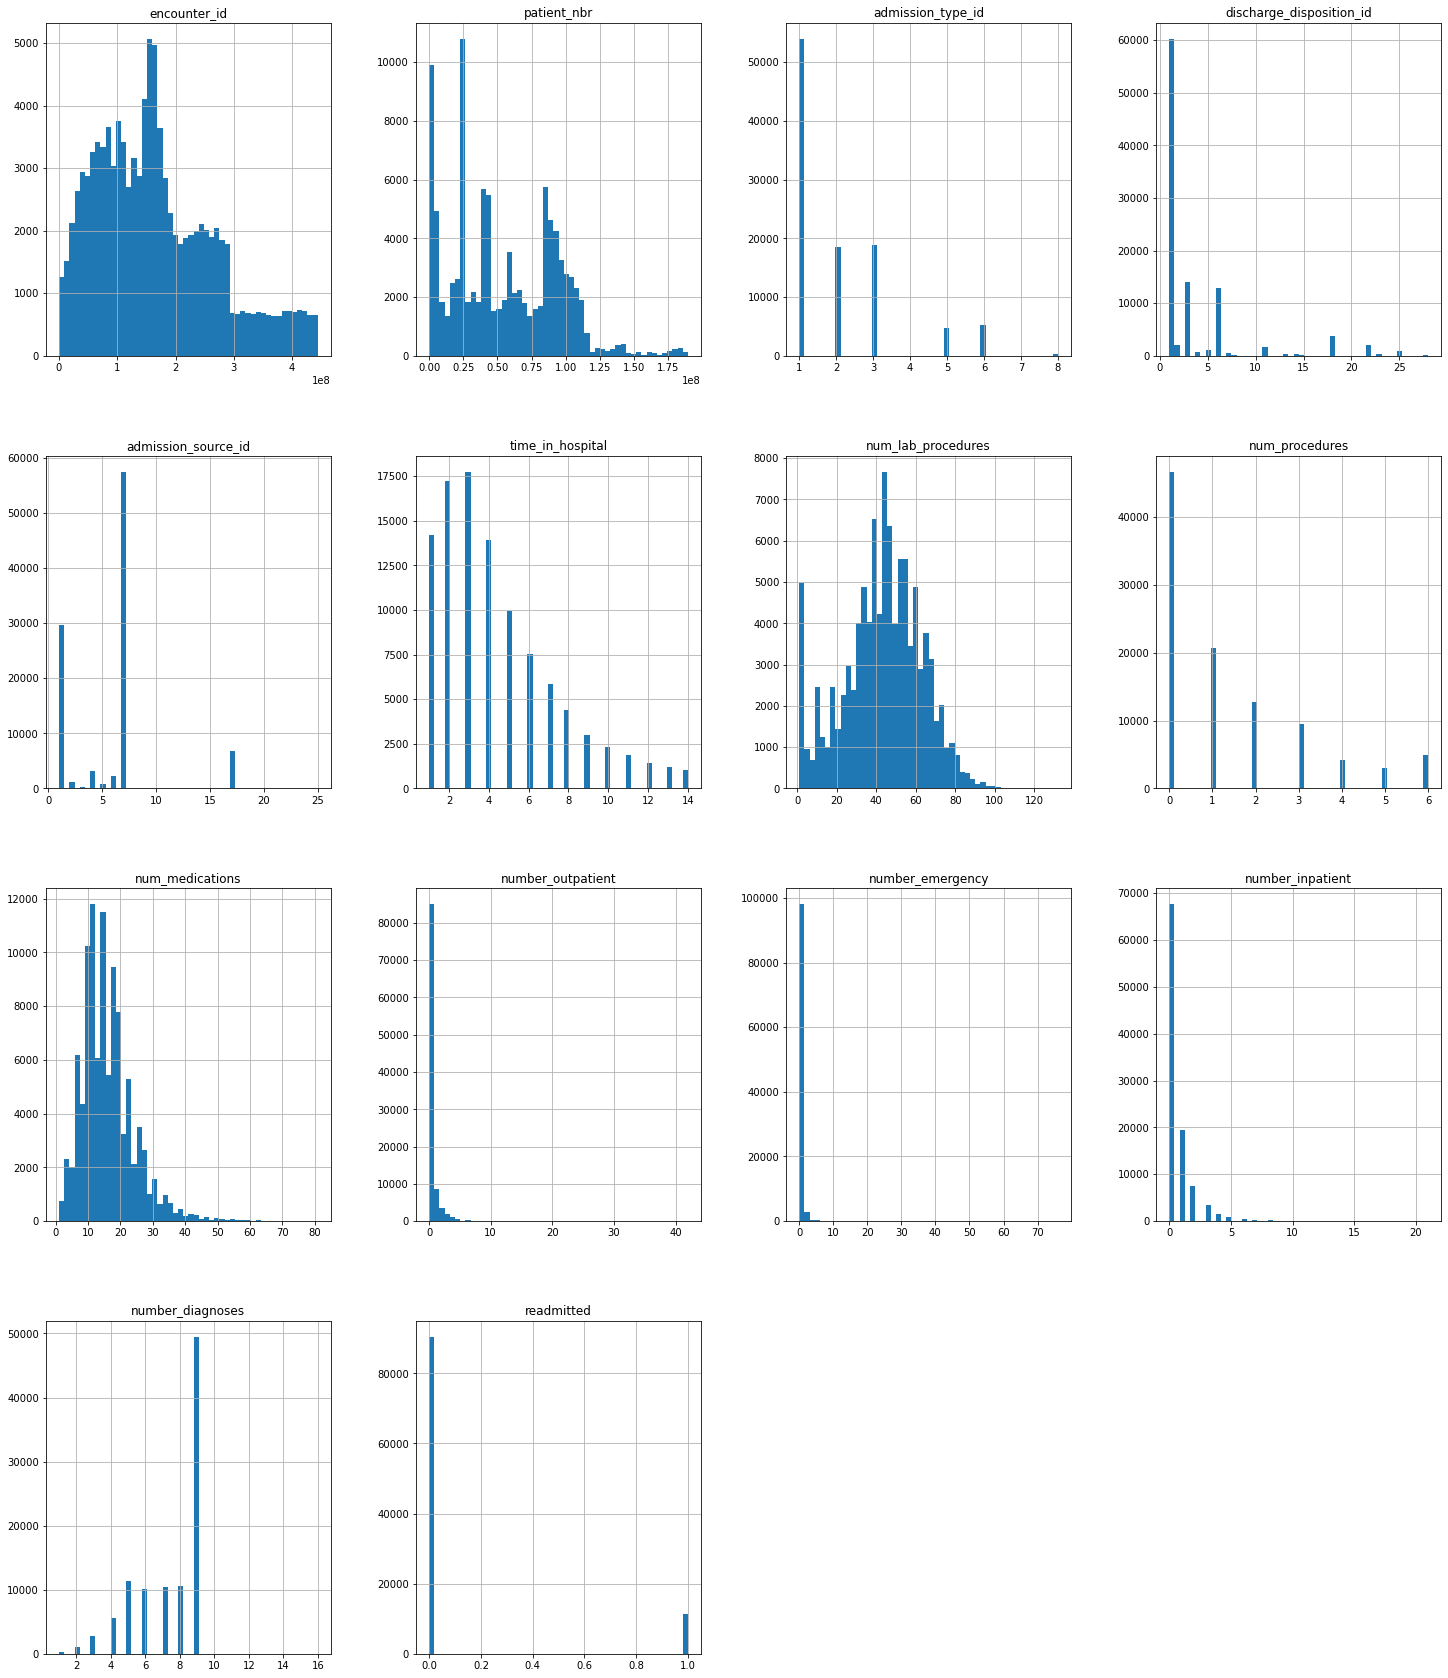

In [40]:
#Visualizing the hist of data
diabetic_df.hist(bins=50,figsize=(25,30))
plt.show()

In [41]:
diabetic_df.corr()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
encounter_id,1.000000,0.512028,-0.158961,-0.132876,-0.112402,-0.062221,-0.026062,-0.014225,0.076113,0.103756,0.082803,0.030962,0.265149,-0.008519
patient_nbr,0.512028,1.000000,-0.011128,-0.136814,-0.032568,-0.024092,0.015946,-0.015570,0.020665,0.103379,0.062352,0.012480,0.226847,0.007893
admission_type_id,-0.158961,-0.011128,1.000000,0.083483,0.106654,-0.012500,-0.143713,0.129888,0.079535,0.026511,-0.019116,-0.038161,-0.117126,-0.011651
discharge_disposition_id,-0.132876,-0.136814,0.083483,1.000000,0.018193,0.162748,0.023415,0.015921,0.108753,-0.008715,-0.024471,0.020787,0.046891,0.050560
admission_source_id,-0.112402,-0.032568,0.106654,0.018193,1.000000,-0.006965,0.048885,-0.135400,-0.054533,0.027244,0.059892,0.036314,0.072114,0.005820
time_in_hospital,-0.062221,-0.024092,-0.012500,0.162748,-0.006965,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186,0.044199
num_lab_procedures,-0.026062,0.015946,-0.143713,0.023415,0.048885,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773,0.020364
num_procedures,-0.014225,-0.015570,0.129888,0.015921,-0.135400,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734,-0.012227
num_medications,0.076113,0.020665,0.079535,0.108753,-0.054533,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526,0.038432
number_outpatient,0.103756,0.103379,0.026511,-0.008715,0.027244,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152,0.018893
